# How Many Books?

Suppose you are the author of a book like *Probably Overthinking It*, and when you visit a local bookstore, like Newtonville Books in Newton, MA, you see that they have two copies of your book on display.

Is it good that they have only a few copies, because it suggests they started with more and sold some? Or is it bad because it suggests they only keep a small number in stock, and they have not sold. More generally, what number of books would you like to see?

To answer these questions, we have to make some modeling decisions. To keep it simple, I'll assume:

* The bookstore orders books on some regular cycle of unknown duration.

* At the beginning of every cycle, they start with `k` books.

* People buy the book at a rate of `λ` books per cycle.

* When you visit the store, you arrive at a random time `t` during the cycle.

We'll start by defining prior distributions for these parameters, and then we'll update it with the observed data. Here are some libraries we'll need.

In [73]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [74]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate

## Priors

For some books, the store only keeps one copy in stock. For others it might keep as many as ten. If we would be equally unsurprised by any value in this range, the prior distribution of `k` is uniform between `1` and `10`.

In [76]:
ks = np.arange(1, 11)
prior_k = Pmf(1, ks)
prior_k.normalize()
prior_k.index.name = 'k'

If we arrive at a random point in the cycle, the prior distribution of `t` is uniform between `0` and `1`, measured in cycles.

In [77]:
ts = np.linspace(0, 1, 21)
prior_t = Pmf(1, ts)
prior_t.normalize()
prior_t.index.name = 't'

Now let's figure the book-buying rate is probably between `2` and `3` copies per cycle, but it could be substantially higher -- with low probability.
We can choose a lognormal distribution that has a mean and shape that seem reasonable.

In [78]:
from scipy.stats import norm

lambdas = np.linspace(0.01, 20, 50)
qs = np.log(lambdas)

mu, sigma = 0.3, 0.7
ps = norm.pdf(qs, mu, sigma)

prior_lambda = Pmf(ps, lambdas)
prior_lambda.normalize()
prior_lambda.index.name = 'lambda'

prior_lambda.mean()

2.7952013319456332

Here's what it looks like.

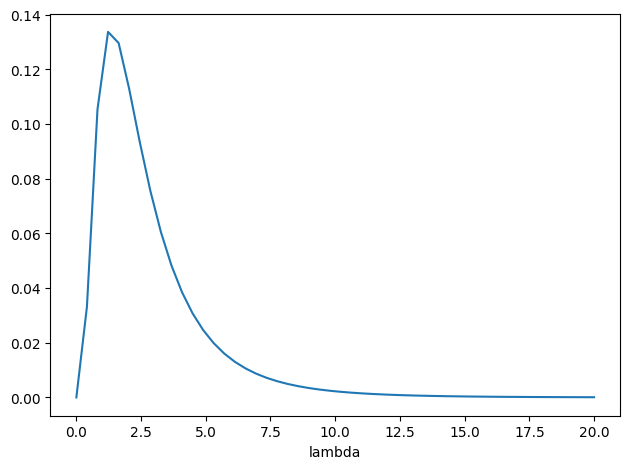

In [79]:
prior_lambda.plot()
decorate()

To form the joint prior distribution, I'll use `meshgrid` with the `ij` indexing order, which  makes the order of the dimensions the same as the order of the arguments: `k`, `λ`, `t`.

In [116]:
def meshgrid(*args, **options):
    if 'indexing' not in options:
        options['indexing'] = 'ij'
    return np.meshgrid(*args, **options)

In [117]:
PK, PLAMBDA, PT = meshgrid(prior_k, prior_lambda, prior_t)
prior = PK * PLAMBDA * PT
prior.shape

(10, 50, 21)

## The update

Now for the update, we have to handle two cases:

* If we observe at least one book, `n`, the probability of the data is the probability of selling `k-n` book at rate `λ` over period `t`, which is given by the Poisson PMF.

* If we see that there are no copies left, we have to add in the probability that the number of books sold in this period could have exceeded `k`, which is given by the Poisson survival function.

The following function computes the probability of the data for all values of the parameters, multiplies by the prior, and normalizes the result.

In [82]:
from scipy.stats import poisson

def update(prior, data):
    n = data
    
    K, LAMBDA, T = meshgrid(ks, lambdas, ts)
    
    like = poisson(mu=LAMBDA*T).pmf(K-n)
    if n == 0:
        like += poisson(mu=LAMBDA*T).sf(K)

    posterior = prior * like
    posterior /= posterior.sum()
    
    return posterior

As an example, we'll do an update with the hypothetically observed `2` books.

In [119]:
n = 2
posterior = update(prior, n)

From the joint posterior, we can extract the marginal distributions of `k` and `λ`, and compute their means.

In [120]:
posterior_k = Pmf(posterior.sum(axis=(1, 2)), ks)
posterior_lambda = Pmf(posterior.sum(axis=(0, 2)), lambdas)

posterior_k.mean(), posterior_lambda.mean()

(3.294088962095148, 2.720709517121936)

Seeing two books suggests that the store starts each cycle with 3-4 books and sells 2-3 per cycle. Here's the posterior distribution of `k` compared to its prior.

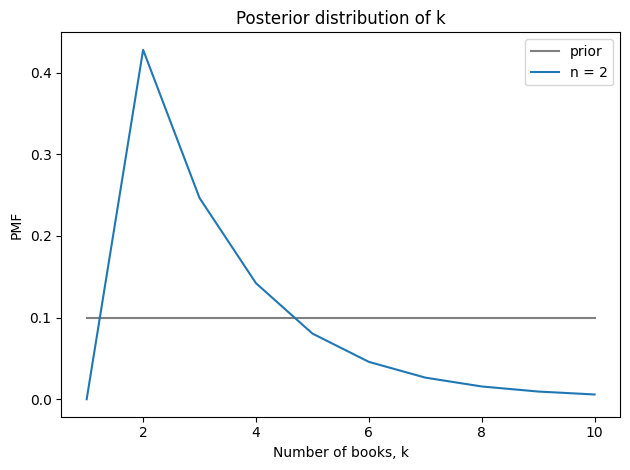

In [123]:
prior_k.plot(label=f'prior', color='gray')
posterior_k.plot(label=f'n = {n}')
decorate(xlabel='Number of books, k',
         ylabel='PMF',
         title='Posterior distribution of k')

And here's the posterior distribution of `λ`.

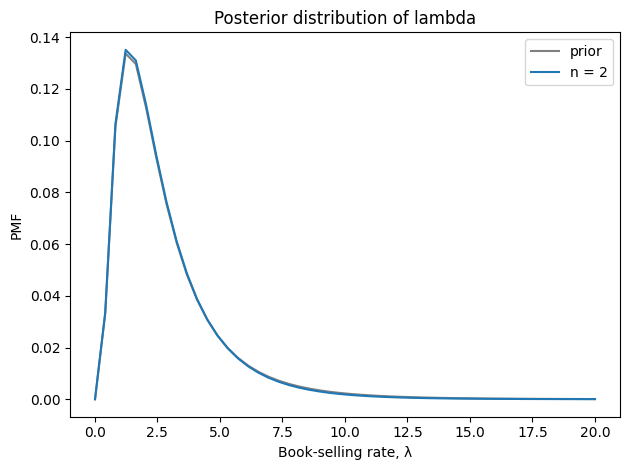

In [122]:
prior_lambda.plot(label='prior', color='gray')
posterior_lambda.plot(label=f'n = {n}')
decorate(xlabel='Book-selling rate, λ',
         ylabel='PMF',
         title='Posterior distribution of lambda')

Seeing two books doesn't provide much information about the book-selling rate.

## Optimization

Now let's consider the more general question, "What number of books would you most like to see?" There are two ways we might answer:

* The observation that leads to the highest estimate of `λ` might seem to be the best. However, that ignore an interaction between `k` and ``
         `

In [87]:
def make_poisson(lam, k):
    qs = np.arange(k+1)
    ps = poisson.pmf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf[k] += poisson.sf(k, lam)
    return pmf

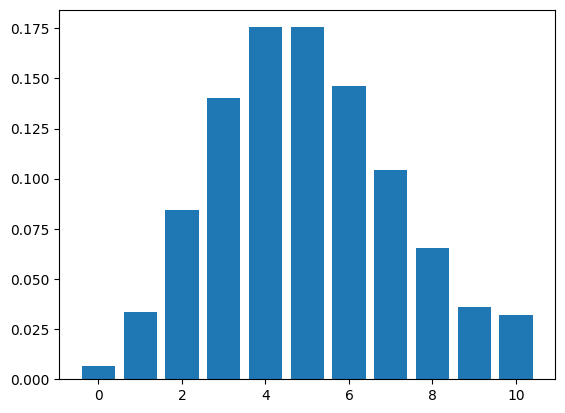

In [88]:
pmf = make_poisson(5, 10)
pmf.bar()

In [91]:
def compute_sales(posterior):
    posterior_joint = posterior.sum(axis=2)
    posterior_joint.shape

    K, LAMBDA = meshgrid(ks, lambdas)
    K.shape

    SALES = posterior_joint * np.minimum(K, LAMBDA)
    return np.sum(SALES)

In [92]:
compute_sales(posterior)

2.449169695342132

In [100]:
def compute_sales(posterior):
    posterior_joint = pd.DataFrame(posterior.sum(axis=2), 
                                   index=ks, columns=lambdas)

    res = []
    for (k, lam), p in posterior_joint.stack().items():
        exp_sales = make_poisson(lam, k).mean()
        res.append((exp_sales, p))
        
    qs, ps = np.transpose(res)
    pmf = Pmf(ps, qs)
    return pmf.mean()

In [101]:
compute_sales(posterior)

2.2695775366862856

In [103]:
res = []

for n in range(11):
    posterior = update(prior, n)
    posterior_k = Pmf(posterior.sum(axis=(1, 2)), ks)
    posterior_lambda = Pmf(posterior.sum(axis=(0, 2)), lambdas)

    k, lam = posterior_k.mean(), posterior_lambda.mean()
    sales = compute_sales(posterior)
    res.append((n, k, lam, sales))

In [104]:
df = pd.DataFrame(res, columns=['n', 'mean k', 'mean lambda', 'exp sales'])
df

,n,mean k,mean lambda,exp sales
0,0,2.409571,4.361937,2.025360
1,1,2.322331,2.740616,1.643844
2,2,3.294089,2.720710,2.036440
3,3,4.254728,2.693604,2.269578
4,4,5.199590,2.656726,2.393205
5,5,6.122093,2.606749,2.441859
6,6,7.013147,2.539618,2.435680
7,7,7.860703,2.450961,2.384995
8,8,8.649959,2.337343,2.295145
9,9,9.365430,2.199540,2.172083


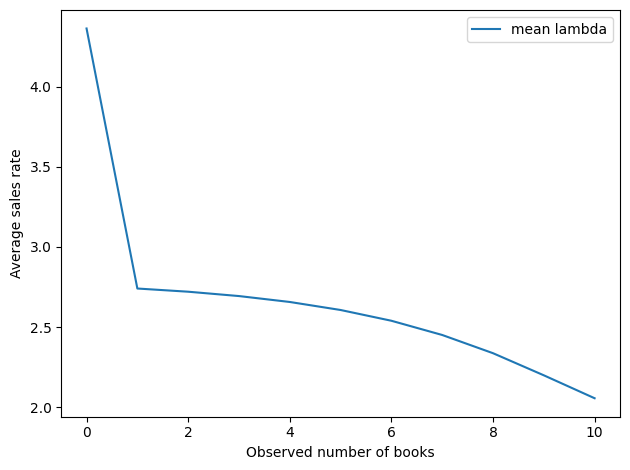

In [105]:
df['mean lambda'].plot()
decorate(xlabel='Observed number of books',
         ylabel='Average sales rate')

5

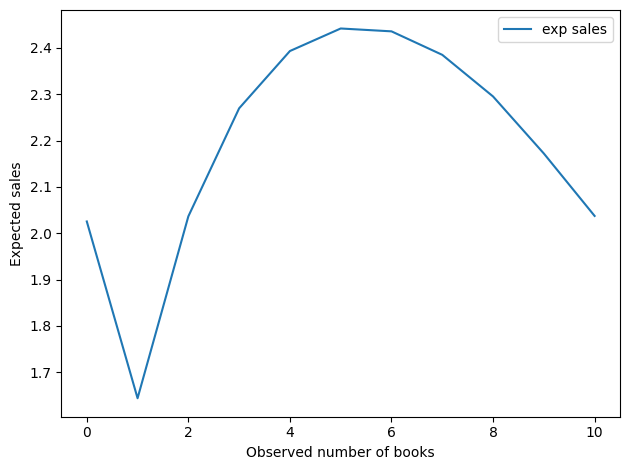

In [106]:
df['exp sales'].plot()
decorate(xlabel='Observed number of books',
         ylabel='Expected sales')
df['exp sales'].argmax()

Thanks to Aubrey Clayton for [this tweet], which gave me the idea for this article.

Copyright 2023 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)